In [1]:
from __future__ import print_function
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
start_time = time.time()

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

# Read the last lines because they are more impacting in training than the starting lines
train = pd.read_csv("train.csv", parse_dates=['click_time'], skiprows=range(1,123903891), nrows=60000000, usecols=train_columns, dtype=dtypes)

print('[{}] Finished to load data'.format(time.time() - start_time))


[120.979460001] Finished to load data


In [3]:
test = pd.read_csv("test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

In [4]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed
0,210014,9,1,13,334,2017-11-08 16:41:52,0
1,2076,3,1,32,211,2017-11-08 16:41:52,0
2,296481,9,1,19,232,2017-11-08 16:41:52,0
3,33473,15,1,13,245,2017-11-08 16:41:52,0
4,115014,3,1,13,137,2017-11-08 16:41:52,0


In [5]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [6]:
len_train = len(train)
train=train.append(test)

In [7]:
del test
gc.collect()

386

In [8]:
train.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os
0,9,334,NaN,2017-11-08 16:41:52,1,210014,0.0,13
1,3,211,NaN,2017-11-08 16:41:52,1,2076,0.0,32
2,9,232,NaN,2017-11-08 16:41:52,1,296481,0.0,19
3,15,245,NaN,2017-11-08 16:41:52,1,33473,0.0,13
4,3,137,NaN,2017-11-08 16:41:52,1,115014,0.0,13


In [9]:
train['hour'] = train.click_time.dt.hour.astype('int8')
train['day'] = train.click_time.dt.day.astype('int8')

In [10]:
train.head(3)

,app,channel,click_id,click_time,device,ip,is_attributed,os,hour,day
0,9,334,NaN,2017-11-08 16:41:52,1,210014,0.0,13,16,8
1,3,211,NaN,2017-11-08 16:41:52,1,2076,0.0,32,16,8
2,9,232,NaN,2017-11-08 16:41:52,1,296481,0.0,19,16,8


In [11]:
def do_next_Click(df, agg_suffix='nextClick', agg_type='float32'):
  
    GROUP_BY_NEXT_CLICKS = [
    
    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']},
    {'groupby': ['device']},
    {'groupby': ['device', 'channel']},     
    {'groupby': ['app', 'device', 'channel']},
    {'groupby': ['device', 'hour']}
    ]

    # Calculate the time to next click for each group
    for spec in GROUP_BY_NEXT_CLICKS:
    
       # Name of new feature
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
    
        # Unique list of features to select
        all_features = spec['groupby'] + ['click_time']

        # Run calculation
        print("Grouping by {}, and saving in {}".format(spec['groupby'], new_feature))
        df[new_feature] = (df[all_features].groupby(spec[
            'groupby']).click_time.shift(-1) - df.click_time).dt.seconds.astype(agg_type)
        gc.collect()
    return (df)

In [12]:
train = do_next_Click(train, agg_suffix='nextClick')
gc.collect()

Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving in ip_app_device_os_channel_nextClick
Grouping by ['ip', 'os', 'device'], and saving in ip_os_device_nextClick
Grouping by ['ip', 'os', 'device', 'app'], and saving in ip_os_device_app_nextClick
Grouping by ['device'], and saving in device_nextClick
Grouping by ['device', 'channel'], and saving in device_channel_nextClick
Grouping by ['app', 'device', 'channel'], and saving in app_device_channel_nextClick
Grouping by ['device', 'hour'], and saving in device_hour_nextClick


0

In [13]:
def do_prev_Click( df,agg_suffix='prevClick', agg_type='float32'):

    GROUP_BY_NEXT_CLICKS = [
    
    # V1
    # {'groupby': ['ip']},
    # {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    # {'groupby': ['ip', 'os']},
    
    # V3
    #{'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    #{'groupby': ['ip', 'os', 'device']},
    #{'groupby': ['ip', 'os', 'device', 'app']}
    ]

    # Calculate the time to next click for each group
    for spec in GROUP_BY_NEXT_CLICKS:
    
       # Name of new feature
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
    
        # Unique list of features to select
        all_features = spec['groupby'] + ['click_time']

        # Run calculation
        print("Grouping by {}, and saving in {}".format(spec['groupby'], new_feature))
        df[new_feature] = (df.click_time - df[all_features].groupby(spec[
                'groupby']).click_time.shift(+1) ).dt.seconds.astype(agg_type)
        
        gc.collect()
    return (df)    

##  Below a function is written to extract unique count feature from different cols
def do_countuniq(df, group_cols, counted, agg_type='uint8', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_countuniq'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCounting unqiue ", counted, " by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
#     print('predictors',predictors)
    gc.collect()
    return( df )

### Below a function is written to extract cumulative count feature  from different cols    
def do_cumcount( df, group_cols, counted,agg_type='uint16', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_cumcount'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCumulative count by ", group_cols , '... and saved in', agg_name  )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
#     print('predictors',predictors)
    gc.collect()
    return( df )

## Below a function is written to extract count feature by aggregating different cols
def do_count( df, group_cols, agg_type='uint16', show_max=False, show_agg=True ):
    agg_name='{}count'.format('_'.join(group_cols))  
    if show_agg:
        print( "\nAggregating by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

In [14]:
train = do_prev_Click( train,agg_suffix='prevClick', agg_type='float32'  ); gc.collect()

train = do_countuniq( train, ['ip'], 'channel' ); gc.collect()
train = do_countuniq( train, ['ip', 'device', 'os'], 'app'); gc.collect()
train = do_countuniq( train, ['ip', 'day'], 'hour' ); gc.collect()
train = do_countuniq( train, ['ip'], 'app'); gc.collect()
train = do_countuniq( train, ['ip', 'app'], 'os'); gc.collect()
train = do_countuniq( train, ['ip'], 'device'); gc.collect()
train = do_countuniq( train, ['app'], 'channel'); gc.collect()
train = do_cumcount( train, ['ip'], 'os'); gc.collect()
train = do_cumcount( train, ['ip', 'device', 'os'], 'app'); gc.collect()


Grouping by ['ip', 'channel'], and saving in ip_channel_prevClick

Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channel_countuniq

Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_countuniq

Counting unqiue  hour  by  ['ip', 'day'] ... and saved in ip_day_by_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_os_countuniq

Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq

Cumulative count by  ['ip'] ... and saved in ip_by_os_cumcount

Cumulative count by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_cumcount


0

In [15]:
train = do_count( train, ['ip', 'day', 'hour'] ); gc.collect()
train = do_count( train, ['ip', 'app']); gc.collect()
train = do_count( train, ['ip', 'app', 'os']); gc.collect()


Aggregating by  ['ip', 'day', 'hour'] ... and saved in ip_day_hourcount

Aggregating by  ['ip', 'app'] ... and saved in ip_appcount

Aggregating by  ['ip', 'app', 'os'] ... and saved in ip_app_oscount


64

In [16]:
del train['day']
gc.collect()
train['dow'] = train['click_time'].dt.dayofweek.astype('int8')
train["doy"] = train["click_time"].dt.dayofyear.astype('int8')

In [17]:
train.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os,hour,ip_app_device_os_channel_nextClick,...,ip_app_by_os_countuniq,ip_by_device_countuniq,app_by_channel_countuniq,ip_by_os_cumcount,ip_device_os_by_app_cumcount,ip_day_hourcount,ip_appcount,ip_app_oscount,dow,doy
0,9,334,NaN,2017-11-08 16:41:52,1,210014,0.0,13,16,NaN,...,22,10,43,0,0,5,65,12,2,56
1,3,211,NaN,2017-11-08 16:41:52,1,2076,0.0,32,16,2691.0,...,57,34,44,0,0,262,3162,48,2,56
2,9,232,NaN,2017-11-08 16:41:52,1,296481,0.0,19,16,NaN,...,13,3,43,0,0,4,41,7,2,56
3,15,245,NaN,2017-11-08 16:41:52,1,33473,0.0,13,16,46609.0,...,29,12,27,0,0,3,248,70,2,56
4,3,137,NaN,2017-11-08 16:41:52,1,115014,0.0,13,16,26104.0,...,24,2,44,0,0,16,412,69,2,56


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78790469 entries, 0 to 78790468
Data columns (total 31 columns):
app                                   uint16
channel                               uint16
click_id                              float64
click_time                            datetime64[ns]
device                                uint16
ip                                    uint32
is_attributed                         float64
os                                    uint16
hour                                  int8
ip_app_device_os_channel_nextClick    float32
ip_os_device_nextClick                float32
ip_os_device_app_nextClick            float32
device_nextClick                      float32
device_channel_nextClick              float32
app_device_channel_nextClick          float32
device_hour_nextClick                 float32
ip_channel_prevClick                  float32
ip_by_channel_countuniq               uint8
ip_device_os_by_app_countuniq         uint8
ip_day_by_hour_c

In [19]:
train.shape

(78790469, 31)

In [20]:
from sklearn.preprocessing import LabelEncoder
train[['app', 'device', 'os', 'channel', 'hour', 'dow', 'doy']] = train[['app', 'device', 'os', 'channel', 'hour', 'dow', 'doy']].apply(LabelEncoder().fit_transform)

In [21]:
test = train[len_train:]
train = train[:len_train]
gc.collect()

133

In [22]:
test.shape

(18790469, 31)

In [23]:
train.shape

(60000000, 31)

In [24]:
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)
gc.collect()

0

In [25]:
import pickle

with open("train.b","wb") as f1, open("test.b","wb") as f2,\
        open("is_attributed.b", "wb") as f3:
    pickle.dump(train, f1)
    pickle.dump(test, f2)
    pickle.dump(y, f3)

In [26]:
import xgboost as xgb
from xgboost import plot_importance

In [27]:
# with open("is_attributed.b","rb") as f2:
#     y = pickle.load(f2)
# with open("train.b","rb") as f2:
#     train = pickle.load(f2)
train.drop(["click_time","click_id","ip"], axis=1, inplace=True)
gc.collect()

7

In [28]:
# Run xgb
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}

dtrain = xgb.DMatrix(train, y)
del train, y
gc.collect()
watchlist = [(dtrain, 'train')]
model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)

[0]	train-auc:0.957413
[1]	train-auc:0.968539
[2]	train-auc:0.972682
[3]	train-auc:0.973809
[4]	train-auc:0.974494
[5]	train-auc:0.976092
[6]	train-auc:0.977639
[7]	train-auc:0.977637
[8]	train-auc:0.97774
[9]	train-auc:0.978947
[10]	train-auc:0.979665
[11]	train-auc:0.979561
[12]	train-auc:0.980019
[13]	train-auc:0.981516
[14]	train-auc:0.98213
[15]	train-auc:0.982598
[16]	train-auc:0.984028
[17]	train-auc:0.985234
[18]	train-auc:0.98578
[19]	train-auc:0.986314
[20]	train-auc:0.986897
[21]	train-auc:0.988172
[22]	train-auc:0.989064
[23]	train-auc:0.989904
[24]	train-auc:0.99052
[25]	train-auc:0.991262
[26]	train-auc:0.991785
[27]	train-auc:0.992557
[28]	train-auc:0.99322
[29]	train-auc:0.993893


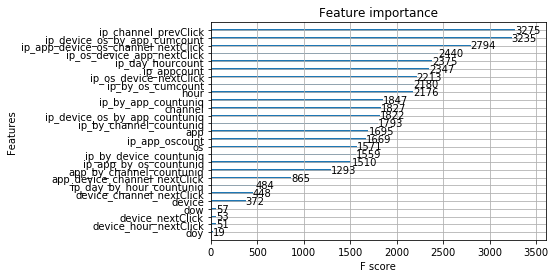

In [29]:
plt.figure(figsize=(15,10))
plot_importance(model)
plt.show()

In [30]:
# with open("test.b","rb") as f2:
#     test = pickle.load(f2)

sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')

test.drop(['click_id','click_time','is_attributed','ip'], axis=1, inplace=True)
dtest = xgb.DMatrix(test)
del test
gc.collect()

# Save the predictions
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub_3.csv', float_format='%.8f', index=False)

In [28]:
import lightgbm as lgb

In [27]:
# lightgbm
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=50, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.05,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0,
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    del dtrain
    del dvalid
    gc.collect()

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[ xgvalid], 
                     valid_names=['valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)

In [49]:
valid_len = 2500000
train['is_attributed'] = y
train_df = train[:-valid_len]
val_df = train[-valid_len:]
print("\ntrain size: ", len(train_df))
print("\nvalid size: ", len(val_df))


train size:  57500000

valid size:  2500000


In [33]:
predictors = train.columns

In [35]:
predictors = list(predictors)

In [54]:
predictors

['app',
 'channel',
 'device',
 'os',
 'hour',
 'ip_app_device_os_channel_nextClick',
 'ip_os_device_nextClick',
 'ip_os_device_app_nextClick',
 'device_nextClick',
 'device_channel_nextClick',
 'app_device_channel_nextClick',
 'device_hour_nextClick',
 'ip_channel_prevClick',
 'ip_by_channel_countuniq',
 'ip_device_os_by_app_countuniq',
 'ip_day_by_hour_countuniq',
 'ip_by_app_countuniq',
 'ip_app_by_os_countuniq',
 'ip_by_device_countuniq',
 'app_by_channel_countuniq',
 'ip_by_os_cumcount',
 'ip_device_os_by_app_cumcount',
 'ip_day_hourcount',
 'ip_appcount',
 'ip_app_oscount',
 'dow',
 'doy']

In [44]:
train.head()

,app,channel,click_id,click_time,device,ip,os,hour,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,...,ip_by_device_countuniq,app_by_channel_countuniq,ip_by_os_cumcount,ip_device_os_by_app_cumcount,ip_day_hourcount,ip_appcount,ip_app_oscount,dow,doy,is_attributed
0,9,112,NaN,2017-11-08 16:41:52,1,210014,13,16,NaN,2936.0,...,10,43,0,0,5,65,12,0,0,0.0
1,3,61,NaN,2017-11-08 16:41:52,1,2076,32,16,2691.0,2690.0,...,34,44,0,0,262,3162,48,0,0,0.0
2,9,72,NaN,2017-11-08 16:41:52,1,296481,19,16,NaN,4.0,...,3,43,0,0,4,41,7,0,0,0.0
3,15,81,NaN,2017-11-08 16:41:52,1,33473,13,16,46609.0,3486.0,...,12,27,0,0,3,248,70,0,0,0.0
4,3,39,NaN,2017-11-08 16:41:52,1,115014,13,16,26104.0,418.0,...,2,44,0,0,16,412,69,0,0,0.0


In [55]:
params = {
        'learning_rate': 0.10,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 7,  # 2^max_depth - 1
        'max_depth': 3,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200 # because training data is extremely unbalanced 
    }
target = 'is_attributed'
(bst,best_iteration) = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=1000)

print('[{}]: model training time'.format(time.time() - start_time))
del train_df
del val_df
gc.collect()


preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	valid's auc: 0.954081
[20]	valid's auc: 0.961689
[30]	valid's auc: 0.966149
[40]	valid's auc: 0.969982
[50]	valid's auc: 0.972899
[60]	valid's auc: 0.975948
[70]	valid's auc: 0.977123
[80]	valid's auc: 0.978308
[90]	valid's auc: 0.979234
[100]	valid's auc: 0.979993
[110]	valid's auc: 0.980495
[120]	valid's auc: 0.980905
[130]	valid's auc: 0.981542
[140]	valid's auc: 0.981963
[150]	valid's auc: 0.982248
[160]	valid's auc: 0.982632
[170]	valid's auc: 0.982952
[180]	valid's auc: 0.983173
[190]	valid's auc: 0.98356
[200]	valid's auc: 0.983747
[210]	valid's auc: 0.983828
[220]	valid's auc: 0.984066
[230]	valid's auc: 0.984197
[240]	valid's auc: 0.984402
[250]	valid's auc: 0.984481
[260]	valid's auc: 0.984523
[270]	valid's auc: 0.984839
[280]	valid's auc: 0.984892
[290]	valid's auc: 0.984997
[300]	valid's auc: 0.985078
[310]	valid's auc: 0.985148
[320]	valid's auc: 0.985219
[330]	valid's auc: 0.9

108

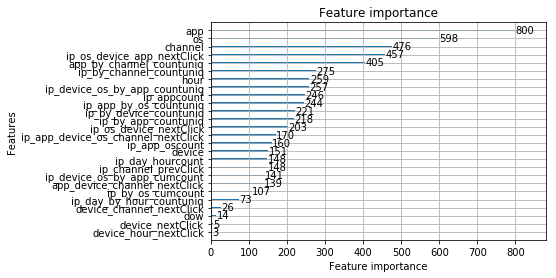

In [56]:
ax = lgb.plot_importance(bst, max_num_features=300)

#plt.savefig('test%d.png'%(fileno), dpi=600,bbox_inches="tight")
plt.show()

In [57]:
    
sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')

gc.collect()

# Save the predictions
sub['is_attributed'] = bst.predict(test[predictors],num_iteration=best_iteration)
sub.to_csv('lgbm_sub_1.csv', float_format='%.9f', index=False)